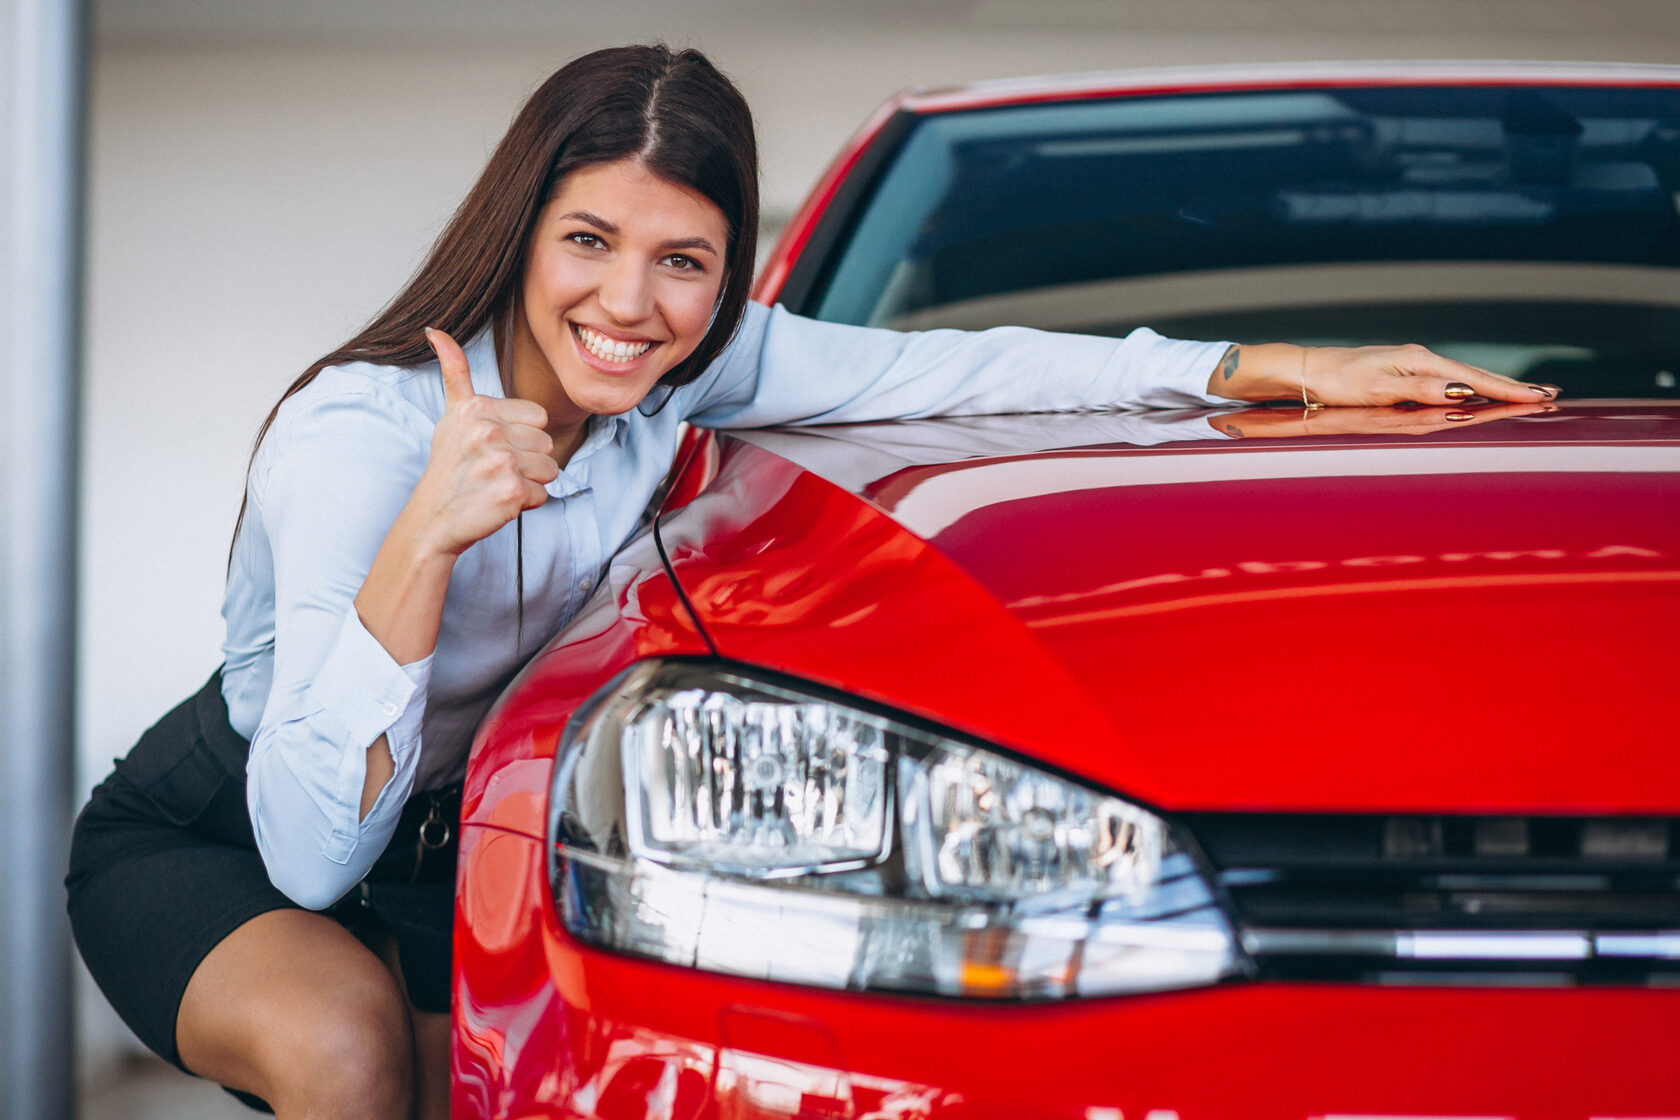

# Предсказание стоимости автомобилей

**Описание проекта:**</br>

**Сервис по продаже подержанных автомобилей разрабатывает приложение, чтобы привлечь новых клиентов.</br> В нём можно будет узнать рыночную стоимость своего автомобиля.</br> 
Наша задача построить такую модель.</br>
В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.**

</br></br>**Для заказчика важны следующие критерии:**</br>
 - **качество предсказания;**
 - **время обучения модели;**
 - **время предсказания модели.**</br></br>
 
 
**Показатель качества модели - метрика RMSE < 2500.** 
 </br>
**В данном проекте будет решаться задача Регрессии с 'учителем', в качестве 'учителя' трейновая часть данных.**


<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#заполнение-пропусков" data-toc-modified-id="заполнение-пропусков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>заполнение пропусков</a></span></li><li><span><a href="#работа-с-аномалиями" data-toc-modified-id="работа-с-аномалиями-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>работа с аномалиями</a></span></li></ul></li><li><span><a href="#Подготовка-выборок-для-обучения-моделей" data-toc-modified-id="Подготовка-выборок-для-обучения-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка выборок для обучения моделей</a></span><ul class="toc-item"><li><span><a href="#модель-Ridge" data-toc-modified-id="модель-Ridge-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>модель Ridge</a></span></li><li><span><a href="#модель-DecisionTreeRegressor" data-toc-modified-id="модель-DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>модель DecisionTreeRegressor</a></span></li><li><span><a href="#модель-LGBMRegresor" data-toc-modified-id="модель-LGBMRegresor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>модель LGBMRegresor</a></span></li><li><span><a href="#модель-CatBoostREgressor" data-toc-modified-id="модель-CatBoostREgressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>модель CatBoostREgressor</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели--DecisionTreeRegressor" data-toc-modified-id="Проверка-лучшей-модели--DecisionTreeRegressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка лучшей модели  DecisionTreeRegressor</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Загрузка данных 

In [1]:
%%capture --no-display
# импортируем библиотеки для работы:

!pip install -U pandas
!pip install -U matplotlib
!pip install -U scikit-learn
!pip install phik


!pip install skimpy
!pip install catboost
!pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
import phik
import category_encoders as ce
import time

import matplotlib.pyplot as plt
from skimpy import clean_columns


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
    
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

NJOBS = -1 # для одновременной работы всех ядер процессора при обучении моделей (для увеличения скорости)
RANDOM = 12345
ITERATIONS = 10 #grid search iteration


In [ ]:
%%time
start = time.time()

Импорт рабочего датасета не показан в соответствии с политикой конфиденциальности ЯП.

In [3]:
# общая инф-ия о данных:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# несколько строк датафрейма:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
322158,2016-03-08 16:57:41,4800,sedan,2005,manual,91,c_max,150000,12,NaN,ford,no,2016-03-08 00:00:00,0,13587,2016-04-07 06:17:07
240808,2016-03-18 10:38:01,600,NaN,2017,manual,75,golf,150000,2,petrol,volkswagen,yes,2016-03-18 00:00:00,0,68623,2016-03-23 17:49:21
107826,2016-03-07 14:38:40,2299,NaN,2017,manual,170,e_klasse,150000,11,gasoline,mercedes_benz,no,2016-03-07 00:00:00,0,49661,2016-03-08 04:46:05
261783,2016-03-07 16:53:32,4200,small,2006,manual,69,polo,150000,2,gasoline,volkswagen,no,2016-03-07 00:00:00,0,27211,2016-04-05 23:46:09
95726,2016-03-30 20:45:25,750,sedan,1993,manual,75,golf,150000,1,petrol,volkswagen,no,2016-03-30 00:00:00,0,25764,2016-04-07 12:47:05
232946,2016-03-09 16:55:47,5000,wagon,2006,manual,150,ptcruiser,150000,6,gasoline,chrysler,no,2016-03-09 00:00:00,0,59065,2016-04-07 06:45:16
100222,2016-03-05 15:49:21,850,sedan,2004,auto,150,vectra,150000,11,gasoline,opel,yes,2016-03-05 00:00:00,0,64347,2016-03-05 16:44:33
295038,2016-03-29 16:37:43,999,sedan,2001,manual,105,147,150000,4,petrol,alfa_romeo,no,2016-03-29 00:00:00,0,56729,2016-03-29 16:37:43
46370,2016-03-12 13:50:01,2000,NaN,2000,manual,0,clk,150000,0,petrol,mercedes_benz,no,2016-03-12 00:00:00,0,80933,2016-03-20 16:18:05
103175,2016-03-10 18:52:45,2500,bus,2004,manual,135,scenic,100000,2,petrol,renault,no,2016-03-10 00:00:00,0,3238,2016-03-11 07:15:59


In [5]:
# описание всех признаков:

df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Видны аномалии в данных:**</br>
1) в `Price` минимальная стоимость = 0 </br>
2) в `RegistrationYear` минимальный год 1000, максимальный - 9999</br>
3) в `Power` максимальная мощность - 2000 л.с. Таких авто мало в природе и скорее всего их точно не будет у нашего заказчика.</br>
4) в `RegistrationMonth`есть месяц 0, когда существуют в реальности от 1 до 12</br>
5) в `NumberOfPictures` сплошные нули, можно смело удалять весь столбец.


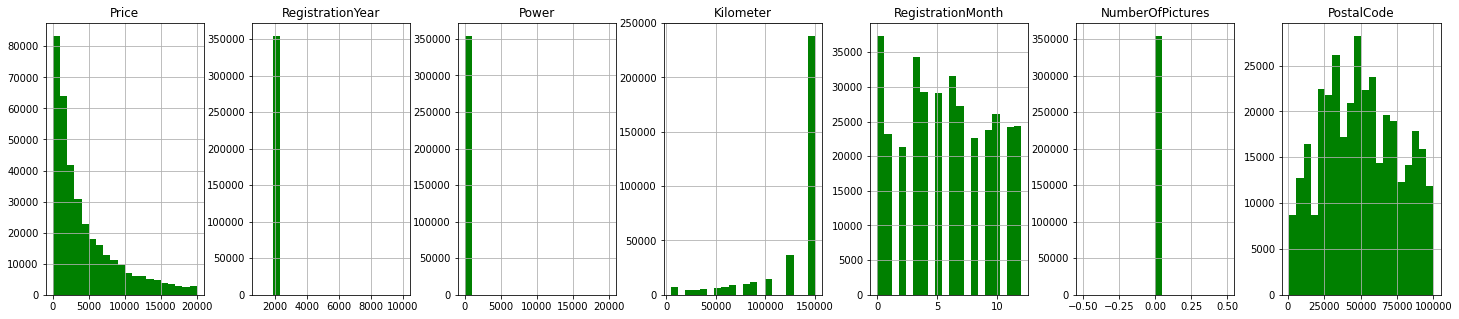

In [6]:
#  отобразим визуально числовые столбцы, используя гистограмму:

df.hist(figsize=(25, 5), color='green', bins=20, layout=(1,7));


## Предобработка данных

In [7]:
# кол-во пропущенных значений и явные дубликаты:

print('Пропуски в данных :\n', df.isna().sum())
print(' ')
print('Явные дубликаты: ', df.duplicated().sum())


Пропуски в данных :
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
 
Явные дубликаты:  4


In [8]:
# удалим явные дубликаты:

df = df.drop_duplicates(keep='first', ignore_index=True)

print('Явные дубликаты: ', df.duplicated().sum())

Явные дубликаты:  0


In [9]:
# приведем названия столбцов в надлежащий вид с помощью библиотеки scimpy:

df_clean = clean_columns(df)

df_clean.columns.tolist()

16 column names have been cleaned

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [10]:
# перезапишем датафрейм: 

df = df_clean

df.sample(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
169791,2016-03-29 11:44:13,1680,small,1996,manual,75,polo,150000,5,petrol,volkswagen,no,2016-03-29 00:00:00,0,30982,2016-04-05 20:18:48
77612,2016-04-01 05:36:55,2800,wagon,2003,manual,101,passat,150000,5,petrol,volkswagen,no,2016-04-01 00:00:00,0,24955,2016-04-03 05:15:58
317050,2016-03-11 19:00:25,2599,sedan,2004,manual,140,altea,150000,9,gasoline,seat,NaN,2016-03-11 00:00:00,0,50735,2016-03-11 19:00:25


In [11]:
# приведем тип данных к нужному формату DateTime:

date_columns = ['date_crawled', 'date_created', 'last_seen']

for column in df[date_columns]:
    df[column] = pd.to_datetime(df[column])
    
    
df[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_crawled  354365 non-null  datetime64[ns]
 1   date_created  354365 non-null  datetime64[ns]
 2   last_seen     354365 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 8.1 MB


In [12]:
# изучим данные в колонке 'brand':

df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [13]:
# заменим 'rover' на 'land_rover':

df['brand'] = np.where((df.brand == 'rover'), 'land_rover', df.brand)


In [14]:
# список уникальных значений в столбце `brand`

len(df.brand.unique())

39

In [15]:
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

**Колонки `vehicle_type`, `gearbox`, `model`, `fuel_type`, `repaired` содежат большой процент пропусков. Изучим и обработаем их.**

### заполнение пропусков

In [16]:
# заполним пропуски в 'vehicle_type' наиболее часто встречающимся по бренду:

df['vehicle_type'] = df.groupby('brand')['vehicle_type'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

df['vehicle_type'].isna().sum()

0

In [17]:
# заполним пропуски в 'gearbox':

df['gearbox'] = df['gearbox'].fillna('unknown')

df['gearbox'].isna().sum()

0

In [18]:
# кол-во пропусков в 'model':

df['model'].isna().sum()

19705

In [19]:
# заполним пропуски в 'model' наиболее встречающимся значением по бренду:

df['model'] = df['model'].fillna(
    df.groupby('brand')['model'].transform(lambda x: x.mode()[0]
                                           if not x.mode().empty else np.nan))


df['model'].isna().sum()

3374

In [20]:
# заполним оставшиеся пропуски в 'model' заглушкой 'other':

df['model'] = df['model'].fillna('other')

df['model'].isna().sum()

0

In [21]:
# изучим данные в колонке 'fuel_type':

df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:
# заменим 'petrol' на 'gasoline', т.к. это одно и то же:

df['fuel_type'] = np.where((df.fuel_type == 'petrol'), 'gasoline', df.fuel_type)

df.fuel_type.unique()


array(['gasoline', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [23]:
# кол-во прпущенных значений в 'fuel_type':

df['fuel_type'].isna().sum()

32895

In [24]:
#Заполним пропуски наиболее часто соответсвующим видом для моделей авто:
df['fuel_type'] = df['fuel_type'].fillna(
    df.groupby('model')['fuel_type'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else np.nan))

df['fuel_type'].isna().sum()


0

In [25]:
# посмотрим уникальные значения в признаке 'repaired', чтобы далее заполнить пропуски в нем:

df.repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

In [26]:
#предположим, что если есть пропуск - то авто не был в ремонте со слов владельцев, т.е. 
# заполним их отрицательным ответом:

df['repaired'] = df['repaired'].fillna('no')

df['repaired'].isna().sum()

0

### работа с аномалиями

**В данных встречаются аномалии(выбросы), рассмотрим их и обработаем далее**

In [27]:
# колонка 'price', посмотрим кол-во строк со стоимостью, ниже 150$, и удалим их при процентном 
# отношении менее 10% всего датафрейма:

print(len(df[df['price'] < 150]) / len(df) *100)


4.213170036544241


In [28]:
# количество таких рядов составляет 4% от всей выборки, поэтому удалим их:

df = df[df['price'] > 150]

In [29]:
# посмотрим в течение какого времени происходило скачаивание данных для работы
# эти данные содержатся в столбце 'date_crawled': 

print('Дата НАЧАЛА скачивания данных:', df.date_crawled.min())
print()
print('Дата ЗАВЕРШЕНИЯ скачивания данных:', df.date_crawled.max())


Дата НАЧАЛА скачивания данных: 2016-03-05 14:06:23

Дата ЗАВЕРШЕНИЯ скачивания данных: 2016-04-07 14:36:58


**Видим, что скачивание данных происходило в течение 1 месяца: c марта по апрель 2016 гг.</br> 
Таким образом, все данные в столбце `date_created` "младше" 2016-04-07 14:36:58,</br> это баг
и подлежат удалению.**

In [30]:
# уберем все записи, где `date_created` младше 2016:

df = df.loc[df['date_created'] <= df.date_crawled.max()]

In [31]:
# проверим даты в `date_created`:

df.date_created.max()

Timestamp('2016-04-07 00:00:00')

In [32]:
# обработаем столбец 'registration_year':
# найдем максимальную дату регистрации анкеты 

df.date_created.max()


Timestamp('2016-04-07 00:00:00')

In [33]:
# т.е. дата регистрации автомобиля врядли может быть "младше" крвйней даты в `date_created`
# расчитаем их процент по отношению ко всему датафрейму и удалим при их числе менее 10%:

print(len(df[df['registration_year'] > 2016])/len(df)*100)


4.035509404249525


In [34]:
# видим 4% данных, и удалим их с чистой совестью:

df = df.loc[df['registration_year'] <= 2016]

In [35]:
#проверим максимальный год регистрации после удаления:

df.registration_year.max()

2016

In [36]:
# обработаем столбец power:
df[df['power'] > 2000]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7661,2016-04-02 19:25:25,1499,small,1999,manual,7515,lupo,150000,4,gasoline,volkswagen,no,2016-04-02,0,65830,2016-04-06 11:46:49
19092,2016-03-20 17:54:04,9750,wagon,2005,auto,2729,5er,150000,7,gasoline,bmw,no,2016-03-20,0,21376,2016-03-23 02:48:53
25232,2016-03-28 19:57:39,10900,bus,2009,manual,10520,caddy,150000,6,gasoline,volkswagen,no,2016-03-28,0,36272,2016-04-07 02:47:02
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,gasoline,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32
44520,2016-03-10 22:37:21,2500,convertible,1998,manual,7512,golf,150000,6,gasoline,volkswagen,no,2016-03-10,0,68239,2016-04-05 15:17:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341316,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,gasoline,citroen,yes,2016-03-29,0,89428,2016-03-31 15:17:03
346635,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,gasoline,mitsubishi,no,2016-03-25,0,42105,2016-04-06 14:44:53
348133,2016-03-16 21:48:39,850,sedan,1993,auto,9012,golf,150000,0,gasoline,volkswagen,no,2016-03-16,0,14482,2016-04-03 09:17:43
348233,2016-04-04 12:38:11,3000,coupe,2007,manual,2007,corsa,150000,3,gasoline,opel,yes,2016-04-04,0,72218,2016-04-04 12:38:11


In [37]:
# удалим 109 рядов:

df = df[df['power'] < 2000]

In [38]:
# удалим столбец 'registration month', т.к. для нас не сильно важен месяц создания, а оставим из
# временной метки только 'registration_year', который и будем считать годом выезда атомобиля
# на дороги общего пользования:

df = df.drop('registration_month', axis=1)

In [39]:
# удалим полностью нулевой столбец `number_of_pictures`,
# а также столбцы `postal_code`, 'date_crawled', `date_created`, `last_seen`,
# как неинформативные для построения модели:

df = df.drop(['number_of_pictures', 'postal_code', 'date_crawled','date_created', 'last_seen' ], axis=1)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 324093 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              324093 non-null  int64 
 1   vehicle_type       324093 non-null  object
 2   registration_year  324093 non-null  int64 
 3   gearbox            324093 non-null  object
 4   power              324093 non-null  int64 
 5   model              324093 non-null  object
 6   kilometer          324093 non-null  int64 
 7   fuel_type          324093 non-null  object
 8   brand              324093 non-null  object
 9   repaired           324093 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.2+ MB


In [40]:
# посчитаем процент оставшихся данных:
# кол-во первоначальных строк = 354369

print('Процент оставшихся записей:', df.shape[0]/354369 * 100)

Процент оставшихся записей: 91.45636328234129


**В результате EDA осталось более 91% данных, что нас вполне устроит для дальнейшей работы** 

In [41]:
# упорядочим индекс после обработки данных:

df.reset_index(drop=True,inplace=True)

**Вывод:**</br>
**1) Загрузили и изучили данные**</br>
**2) Обработали пропуски**</br>
**3) Обработали аномальные значения в данных**</br>
**4) Удалили неинформативные признаки**</br>

**Датасет готов для дальнейшей работы**

## Подготовка выборок для обучения моделей

**Согласно условию проекта, нужно создать и обучить модели:</br> -LightGBM</br>  -как минимум одну НЕ БУСТИНГ (возьмем Ridge)</br>
-третьей моделью будет RandomForestRegressor**

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


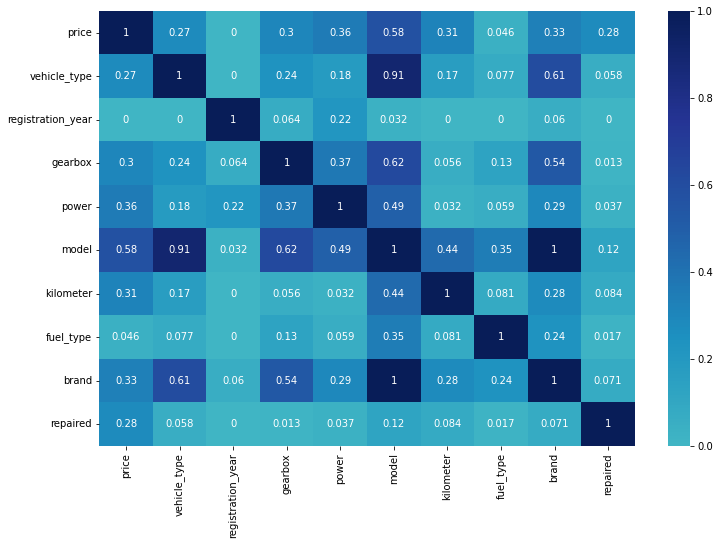

In [42]:
#Т.к обучаем Линейные модели, нам важно отсутствие коллинеарности признаков, изучим с помощью библиотеки phi_k:
#построим тепловую карту корреляции:

plt.figure(figsize=(12,8))

sns.heatmap(df.phik_matrix(),
            cmap='YlGnBu',
            center=0,
            annot=True,
            );


 **Наблюдаем высокую корреляцию  0.9 между признаками  `vehicle_type` и `model`. Удалим  `vehicle_type`, т.к. изначально в нем меньше уникальных признаков и в нем было множество пропусков.**

In [43]:
df = df.drop(['vehicle_type'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324093 entries, 0 to 324092
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              324093 non-null  int64 
 1   registration_year  324093 non-null  int64 
 2   gearbox            324093 non-null  object
 3   power              324093 non-null  int64 
 4   model              324093 non-null  object
 5   kilometer          324093 non-null  int64 
 6   fuel_type          324093 non-null  object
 7   brand              324093 non-null  object
 8   repaired           324093 non-null  object
dtypes: int64(4), object(5)
memory usage: 22.3+ MB


In [44]:
# выделим в выборке фичи и таргет и разделим на тестовую и трейновую части:

features = df.drop(['price'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM)

print(f'Размер X_train = {X_train.shape[0]/len(df):.0%}')
print(f'Размер X_test = {X_test.shape[0]/len(df):.0%}')
print()
print(f'Размер y_train = {X_train.shape[0]/len(df):.0%}')
print(f'Размер y_test = {y_test.shape[0]/len(df):.0%}')

Размер X_train = 75%
Размер X_test = 25%

Размер y_train = 75%
Размер y_test = 25%


In [45]:
# размерности выборок:

print(X_train.shape, X_test.shape)


(243069, 8) (81024, 8)


**Проведем кодирование категориальных признаков. Будем применять OHE-кодирование для 'gearbox', 'fuel_type', 'repaired',
а MEstimateEncoder для столбцов 'model' и 'brand', т.к. они содержат большое количество категорий и в случае применения
OHE "разрастят" датафрейм до 300+ признаков, что скажется на скорости и качестве работы модели:**

In [46]:
# создание энкодера MEstimateEncoder():

me_encoder = ce.MEstimateEncoder(cols=['model', 'brand'])

In [47]:
# обучим и применим энкодер к трейновой выборке:
me_encoder.fit(X_train, y_train)

X_train_cleaner = me_encoder.transform(X_train)

In [48]:
#демонстрация работы энкодера:

X_train_cleaner.sample(5)

,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
54479,2005,manual,95,3528.116882,100000,gasoline,6113.955786,no
120981,2016,manual,90,2875.590241,150000,gasoline,2935.741530,no
281389,2002,unknown,50,1526.526582,150000,gasoline,2430.460720,yes
22393,1995,manual,60,4263.215804,150000,gasoline,4677.604744,no
48966,2005,manual,111,5730.361495,150000,gasoline,5335.346676,no


In [49]:
# применим энкодер к тестовой выборке:

X_test_cleaner = me_encoder.transform(X_test)

#демонстрация работы энкодера на тестовой выборке:

X_test_cleaner.sample(5)

,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
235666,1994,manual,55,5493.589211,150000,gasoline,6113.955786,no
250124,2006,manual,105,4710.834078,150000,gasoline,4677.604744,no
303474,2008,auto,105,4263.215804,80000,gasoline,4677.604744,no
49356,2007,manual,65,3533.127622,100000,gasoline,5251.003006,no
304965,2007,auto,224,9625.792656,125000,gasoline,6113.955786,no


**OHE-кодирование остальных категориальных признаков:**

In [50]:
#создадим OHE-encoder:

ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)


In [51]:
X_train.sample(10)

,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
274210,2004,auto,150,vito,150000,gasoline,mercedes_benz,no
305176,1987,auto,132,other,150000,gasoline,mercedes_benz,no
171587,2008,manual,45,fortwo,150000,gasoline,smart,no
115569,1993,manual,54,polo,150000,gasoline,volkswagen,no
106065,1997,manual,0,golf,150000,gasoline,volkswagen,no
192514,2000,manual,60,fiesta,125000,gasoline,ford,no
264021,2001,manual,75,golf,150000,gasoline,volkswagen,no
162642,2006,manual,170,golf,150000,gasoline,volkswagen,no
120315,2012,manual,60,polo,50000,gasoline,volkswagen,no
79975,2011,manual,86,jimny,70000,gasoline,suzuki,no


In [52]:
# применим OHE-кодирование категориальных 'gearbox', 'fuel_type', 'repaired':

ohe_encoder.fit(X_train[['gearbox', 'fuel_type', 'repaired']])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [53]:
# добавляем закодированные признаки в X_train:

X_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(X_train[['gearbox', 'fuel_type', 'repaired']])

In [54]:
# удаляем незакодированные категориальные признаки (изначальные колонки)

X_train = X_train.drop(['gearbox', 'fuel_type', 'repaired'], axis=1)

X_train.sample(10)

,registration_year,power,model,kilometer,brand,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes
124997,1990,283,other,150000,nissan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
181414,2008,140,zafira,90000,opel,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104198,2003,163,cooper,150000,mini,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104227,2004,211,vectra,150000,opel,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
227903,2000,86,ibiza,70000,seat,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
226814,2004,102,touran,100000,volkswagen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
211341,2007,140,touran,150000,volkswagen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
204386,1994,0,transporter,150000,volkswagen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
315428,2015,73,clio,5000,renault,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
201403,1998,102,a_klasse,150000,mercedes_benz,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
# Применим к тестовой выборке:
X_test[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(X_test[['gearbox', 'fuel_type', 'repaired']])


In [56]:
# удаляем незакодированные категориальные признаки (изначальные колонки)

X_test = X_test.drop(['gearbox', 'fuel_type', 'repaired'], axis=1)

X_test.sample(10)

,registration_year,power,model,kilometer,brand,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes
184156,2003,173,other,150000,hyundai,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99179,2000,60,corsa,150000,opel,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
308461,1999,132,4_reihe,150000,peugeot,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
312108,2012,85,polo,80000,volkswagen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
292838,2006,231,5er,150000,bmw,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
219999,1995,45,polo,125000,volkswagen,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
118915,1996,158,voyager,150000,chrysler,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59115,1996,150,3er,150000,bmw,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110612,2009,80,corsa,125000,opel,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
320794,2002,75,corsa,150000,opel,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Объединим колонки от разных типов кодирования в единые новые выборки X_train_new и X_test_new:**

In [57]:
# удалим столбцы 'model' и 'brand' в X_train и X_test:

X_train_new = X_train.drop(labels = ['model', 'brand'], axis=1)

X_test_new = X_test.drop(labels = ['model', 'brand'], axis=1)


display(X_train_new.head(5))

display(X_test_new.head(5))


,registration_year,power,kilometer,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes
315260,2016,45,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
216425,2000,50,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
64057,2011,90,70000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
128575,1999,54,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
188405,2003,58,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,registration_year,power,kilometer,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes
60744,2000,90,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
31817,2000,75,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107046,2003,101,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
90628,2003,84,60000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
113659,2005,116,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [58]:
# поместим столбцы 'model' и 'brand' из X_train_cleaner и X_test_cleaner в X_train_new и X_test_new:

X_train_new['model'] = X_train_cleaner['model']
X_train_new['brand'] = X_train_cleaner['brand']

X_test_new['model'] = X_test_cleaner['model']
X_test_new['brand'] = X_test_cleaner['brand']


display(X_train_new.head(5))
display(X_test_new.head(5))

,registration_year,power,kilometer,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes,model,brand
315260,2016,45,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2050.905156,2935.741530
216425,2000,50,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1468.026379,4677.604744
64057,2011,90,70000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3766.905750,4268.906418
128575,1999,54,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2008.686092,4301.641417
188405,2003,58,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2050.905156,2935.741530


,registration_year,power,kilometer,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes,model,brand
60744,2000,90,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2233.319738,2430.460720
31817,2000,75,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3766.905750,4268.906418
107046,2003,101,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3197.586230,2935.741530
90628,2003,84,60000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3197.586230,2935.741530
113659,2005,116,150000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9920.063942,9249.388193


**Проведем масштабирование численных признаков,включая обновленные столбцы brand и model, ставшие после MEStimate-кодирования также числовыми.**


In [59]:
# выделим числовые признаки:

numeric = ['power', 'kilometer', 'registration_year', 'model', 'brand']

In [60]:
scaler = StandardScaler()
scaler.fit(X_train_new[numeric])

#применим к выборкам:
X_train_new[numeric] = scaler.transform(X_train_new[numeric])
X_test_new[numeric] = scaler.transform(X_test_new[numeric])

X_test_new.head(10)

,registration_year,power,kilometer,gearbox_manual,gearbox_unknown,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,repaired_yes,model,brand
60744,-0.214074,-0.291343,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.017659,-1.517670
31817,-0.214074,-0.506389,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.381823,-0.282371
107046,0.035858,-0.133644,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.617867,-1.178159
90628,0.035858,-0.377362,-1.832377,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.617867,-1.178159
113659,0.202479,0.081401,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.169320,3.064141
155026,-0.547317,-0.936479,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.093290,-1.178159
69711,0.369100,-0.506389,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.017659,-1.517670
161704,-0.047453,0.267774,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.334072,0.957364
256600,-0.130764,-0.047626,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.855793,-1.517670
178161,0.035858,0.138747,0.583604,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.314932,-0.260376


**В результате применения кодировщиков OneHotEncoder и MEstimateEncoder и StandardScaler, привели данные в удобный для работы моделей вид.**

### модель Ridge

**Создадим и обучим модель Ridge**

In [61]:
ridge_model = Ridge(random_state=RANDOM)

In [62]:
# Для поиска лучших параметров модели,
# применим GridSearchCV, который имеет встроенную кросс-валидацию для модели Ridge

# создаем словарь гиперпараметров:
gs_param= {
    'alpha': np.arange(0, 0.21, 0.01),
}

# объект GridSearchCV:
gs_ridge = GridSearchCV(
    ridge_model, 
    param_grid=gs_param, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=NJOBS
)

In [63]:
# обучим GridSearchCV на тренировочной выборке:
gs_ridge.fit(X_train_new, y_train)

# лучшее значение RMSE на кросс-валидации
print(f'best RMSE score: {gs_ridge.best_score_ * -1}')

# лучшие гиперпараметры
print(f'best params: {gs_ridge.best_params_}')

best RMSE score: 3140.2728312848294
best params: {'alpha': 0.2}


**Найдем время обучения и предсказания:**

In [64]:
 # из атрибута GridSearchCV  `с_results_` извлечем максимальное время обучения и предсказания:   
ridge_fit_time = gs_ridge.cv_results_['mean_fit_time'].max()
ridge_fit_time

0.4305020809173584

In [65]:
# максимальное время предсказания:
ridge_score_time = gs_ridge.cv_results_['mean_score_time'].max()
ridge_score_time

0.013787651062011718

### модель DecisionTreeRegressor

**Создадим и обучим модель DecisionTreeRegressor:**

In [66]:
# создание модели DecisionTree:

model_dt = DecisionTreeRegressor(random_state = RANDOM)


# словарь с гиперпараметрами для модели DecisionTree:

dt_param = {'splitter': ['best', 'random'],                          #default='best'
            'max_depth': [i for i in range(3, 42, 5)],               #default=None
            'min_samples_leaf': [i for i in range(1, 25)],           #default=1
            'max_leaf_nodes': [None]+[10*i for i in range(1, 31)]    #default=None
              
}

In [67]:
# поиск наилучших гиперпараметров по RandomizedSearchCV:

dt_rs = RandomizedSearchCV(model_dt,
                           param_distributions=dt_param,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           random_state=RANDOM
                          )

In [68]:
# обучим объект RandomizedSearchCV:

dt_rs.fit(X_train_new, y_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 8, 13, 18, 23, 28, 33,
                                                      38],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100, 110, 120, 130,
                                                           140, 150, 160, 170,
                                                           180, 190, 200, 210,
                                                           220, 230, 240, 250,
                                                           260, 270, 280, 290, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24],
                                        'splitter': ['best', 'random']},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [69]:
# найдем наилучшие параметры RMSE: 

dt_rs_best_score = dt_rs.best_score_ * -1
dt_rs_best_params = dt_rs.best_params_
print(f'best_score: {dt_rs_best_score}')
print(f'best_params: {dt_rs_best_params}')

best_score: 1803.2901969771367
best_params: {'splitter': 'best', 'min_samples_leaf': 8, 'max_leaf_nodes': None, 'max_depth': 18}


**Время обучения и предсказания:**

In [70]:
# для наглядности, все параметры, которые содержит объект RandomizedSearchCV:

dt_rs.cv_results_

{'mean_fit_time': array([0.66442289, 0.85692143, 0.53585386, 0.80736837, 0.73321776,
        0.89043932, 1.11915336, 0.66771989, 0.30543442, 0.43999572]),
 'std_fit_time': array([0.0151371 , 0.04557913, 0.02131169, 0.01372491, 0.03313308,
        0.01417161, 0.01249584, 0.02703812, 0.01552014, 0.01339083]),
 'mean_score_time': array([0.01330571, 0.01303706, 0.01336703, 0.01038442, 0.01755986,
        0.01104517, 0.02197614, 0.01624904, 0.00587873, 0.00735297]),
 'std_score_time': array([0.00453779, 0.00629502, 0.00675312, 0.00785309, 0.00142617,
        0.0070215 , 0.00597524, 0.00042365, 0.0061182 , 0.00279354]),
 'param_splitter': masked_array(data=['best', 'random', 'random', 'best', 'random', 'best',
                    'best', 'random', 'best', 'random'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[10, 19, 9, 19, 13, 8

In [71]:
 # из атрибута RandomizedSearchCV  `с_results_` извлечем максимальное время обучения и предсказания:
    
tree_fit_time = dt_rs.cv_results_['mean_fit_time'].max()
tree_fit_time 

1.1191533565521241

In [72]:
# максимальное время предсказания:
tree_score_time = dt_rs.cv_results_['mean_score_time'].max()
tree_score_time

0.021976137161254884

### модель LGBMRegresor

In [73]:
# создадим модель Light GBM:

lgbr = LGBMRegressor(random_state=RANDOM, n_jobs=NJOBS)

In [74]:
# список параметров:

param = {
              'num_leaves':[5, 10, 20, 30],
              'min_child_samples': [10, 50, 100, 150],
              'max_depth': [3, 8, 12, 15],
              'learning_rate': [0.01, 0.05, 0.15, 0.3]}

In [75]:
# объект RandomizedSearchCV для поиска наилучших гиперпараметров:

lgbr_rs = RandomizedSearchCV(estimator=lgbr,
                            param_distributions=param,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=NJOBS,
                            cv=5,
                            random_state=RANDOM,
                            n_iter=ITERATIONS)

In [76]:
#обучим lgbr _search на трейновой выборке:

lgbr_rs.fit(X_train_new, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 243069, number of used features: 11
[LightGBM] [Info] Start training from score 4689.139705


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(n_jobs=-1, random_state=12345),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.15,
                                                          0.3],
                                        'max_depth': [3, 8, 12, 15],
                                        'min_child_samples': [10, 50, 100, 150],
                                        'num_leaves': [5, 10, 20, 30]},
                   random_state=12345, scoring='neg_root_mean_squared_error')

In [77]:
#наилучшие параметры:

lgbr_rs_best_score = lgbr_rs.best_score_ * -1
lgbr_rs_best_params = lgbr_rs.best_params_
print(f'best_score: {lgbr_rs_best_score}')
print(f'best_params: {lgbr_rs_best_params}')

best_score: 1744.9223279849962
best_params: {'num_leaves': 30, 'min_child_samples': 150, 'max_depth': 15, 'learning_rate': 0.15}


In [78]:
 # из атрибута RandomizedSearchCV  `с_results_` извлечем максимальное время обучения и предсказания: 
    
lgbr_fit_time = lgbr_rs.cv_results_['mean_fit_time'].max()
lgbr_fit_time 

6.371914577484131

In [79]:
# максимальное время предсказания:
lgbr_score_time = lgbr_rs.cv_results_['mean_score_time'].max()
lgbr_score_time 

0.08307099342346191

### модель CatBoostREgressor

In [80]:
# создадим модель Катбуста:

model_cbr = CatBoostRegressor(loss_function='RMSE',
                              task_type='CPU',
                              verbose=False,
                              random_state=RANDOM)

In [81]:
# список гиперпараметров:

param_cbr = {
    'iterations': range(300, 901, 150),
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': range(2, 11, 2),
    'reg_lambda': [1, 5, 10]
}

In [82]:
# использование randomized_search для поиска наилучших гиперпараметров:

cbr_rs = RandomizedSearchCV(estimator= model_cbr,
                            param_distributions=param_cbr,
                            scoring='neg_root_mean_squared_error',   
                            n_iter=ITERATIONS,
                            verbose=False,
                            n_jobs=NJOBS,
                            cv=5)

In [83]:
# обучим объект RandomizedSearchCV на трейновой выборке:

cbr_rs.fit(X_train_new, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x000001CDD969A130>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 11, 2),
                                        'iterations': range(300, 901, 150),
                                        'learning_rate': [0.01, 0.03, 0.05],
                                        'reg_lambda': [1, 5, 10]},
                   scoring='neg_root_mean_squared_error', verbose=False)

In [84]:
# наилучшие параметры:

cbr_rs_best_score = cbr_rs.best_score_ * -1
cbr_rs_best_params = cbr_rs.best_params_
print(f'best_score: {cbr_rs_best_score}')
print(f'best_params: {cbr_rs_best_params}')

best_score: 1682.7938499006182
best_params: {'reg_lambda': 1, 'learning_rate': 0.05, 'iterations': 600, 'depth': 10}


In [85]:
# из атрибута RandomizedSearchCV  `с_results_` извлечем максимальное время обучения и предсказания:

cbr_fit_time = cbr_rs.cv_results_['mean_fit_time'].max()
cbr_fit_time

99.13028111457825

In [86]:
# максимальное время предсказания:
cbr_score_time = cbr_rs.cv_results_['mean_score_time'].max()
cbr_score_time

0.1544722557067871

**Поместим все результаты в одну табличку для наглядности**

In [87]:

data = {'RMSE': [-gs_ridge.best_score_, -dt_rs.best_score_, -lgbr_rs.best_score_, -cbr_rs.best_score_],
       'max_time_fit':[ridge_fit_time, tree_fit_time, lgbr_fit_time, cbr_fit_time],
       'max_time_score':[ridge_score_time, tree_score_time, lgbr_score_time, cbr_score_time]}

result = pd.DataFrame(data,  index=['Ridge', 'DecisionTreeRegressor','LGBMRegresor', 'CatBoostREgressor'])

round(result, 3)


,RMSE,max_time_fit,max_time_score
Ridge,3140.273,0.431,0.014
DecisionTreeRegressor,1803.290,1.119,0.022
LGBMRegresor,1744.922,6.372,0.083
CatBoostREgressor,1682.794,99.130,0.154


**Лучшая модель по качеству предсказания - это LGBMRegresor(RMSE = 1744), но не устраивает время ее обучения.</br> Поэтому выберем модель DecisionTreeRegressor, у которой выполняется условие RMSE < 2500, а также наименьшее из подходящих по RMSE моделей время обучения и предсказания.**

## Проверка лучшей модели  DecisionTreeRegressor

In [88]:
dt_prediction = dt_rs.predict(X_test_new)

RMSE = mean_squared_error(y_test, dt_prediction, squared=False)

print('RMSE лучшей модели = ', round(RMSE))

end = time.time()

RMSE лучшей модели =  1797


**Видим, что RMSE = 1797 на тестовой выборке, что нас устраивает.**

In [89]:
#определим время выполнения ноутбука с помощью библиотеки time:

print('Время выполнение ноутбука с проектом составляет (в минутах:):', round((end - start)/60, 0))

Время выполнение ноутбука с проектом составляет (в минутах:): 6.0


## Общий вывод

**В результате работы выполнено следующее:**

- Проведен анализ данных, устранены аномалии, дубликаты и пропуски, всего около 9%, что вписывается в общепринятые в DS 
(удаление не более 10% исходных данных).
- Подготовлены признаки и таргет, произведена проверка на коллинеарность признаков и устранены коллинеарные столбцы.
- Преобразования категориальных признаков выполнена с помощью двух методов: OHE_ и MEstimate_ кодирование.
- Произведена нормирование численных признаков с помощью StandartScaler.
- Созданы новые выборки X_train_new и X_test_new.
- Протестированы модели Ridge, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor.
- Произведен поиск по сетке лучших гиперпараметров моделей с помощью Randomized SearchCV и GridSearchCV.
- В результате лучшей моделью стала DecisionTreeRegressor, из-за времени обучения и предсказания. Хотя лучший RMSE
оказался у модели LGBMRegresor	 = 1744, но нас не устраивает время вычислений.
- Вычислено быстродействие всех моделей на обучении и предсказании.
- Выбрана лучшая модель и проверена на тестовой выборке.
- Определили время выполнения проекта в ноутбуке, оно составляет 8 минут, что является приемлемым.